# Days since first hospitalization

- Fit the doubling time based on all other input parameters by asking the user for 1 additional input: the number of days that have passed since the first hospitalization of a COVID19 patient.
- Allows the user to line up historical predicted hospitalizations with actuals.
- Properly seeds S, I, and R at current day by starting back at the time of the first hospitalization.
- Fitting process has the advantage of being _simple_, only requiring 1 additional input from the user.

In [1]:
%pylab inline
import pandas as pd
from typing import Dict, Generator, Tuple

Populating the interactive namespace from numpy and matplotlib


In [2]:
def sir(
    s: float, i: float, r: float, beta: float, gamma: float, n: float
) -> Tuple[float, float, float]:
    """The SIR model, one time step."""
    s_n = (-beta * s * i) + s
    i_n = (beta * s * i - gamma * i) + i
    r_n = gamma * i + r
    if s_n < 0.0:
        s_n = 0.0
    if i_n < 0.0:
        i_n = 0.0
    if r_n < 0.0:
        r_n = 0.0

    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale


def gen_sir(
    s: float, i: float, r: float, beta: float, gamma: float, n_days: int,
) -> Generator[Tuple[float, float, float], None, None]:
    """Simulate SIR model forward in time yielding tuples."""
    s, i, r = (float(v) for v in (s, i, r))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r
        s, i, r = sir(s, i, r, beta, gamma, n)


def sim_sir_df(
    s: float, i: float, r: float, beta: float, gamma: float, n_days
) -> pd.DataFrame:
    """Simulate the SIR model forward in time."""
    return pd.DataFrame(
        data=gen_sir(s, i, r, beta, gamma, n_days),
        columns=("day", "susceptible", "infected", "recovered"),
    )


def get_dispositions(
    patients: np.ndarray,
    rates: Dict[str, float],
    market_share: float,
) -> Dict[str, np.ndarray]:
    """Get dispositions of patients adjusted by rate and market_share."""
    return {
        key: patients * rate * market_share
        for key, rate in rates.items()
    }


def build_admits_df(n_days, dispositions) -> pd.DataFrame:
    """Build admits dataframe from Parameters and Model."""
    days = np.arange(0, n_days + 1)
    projection = pd.DataFrame({
        "day": days,
        **dispositions,
    })
    # New cases
    admits_df = projection.iloc[:-1, :] - projection.shift(1)
    admits_df["day"] = range(admits_df.shape[0])
    return admits_df


def build_census_df(
    admits_df: pd.DataFrame, lengths_of_stay
) -> pd.DataFrame:
    """ALOS for each category of COVID-19 case (total guesses)"""
    n_days = np.shape(admits_df)[0]
    census_dict = {}
    for key, los in lengths_of_stay.items():
        census = (
            admits_df.cumsum().iloc[:-los, :]
            - admits_df.cumsum().shift(los).fillna(0)
        ).apply(np.ceil)
        census_dict[key] = census[key]

    census_df = pd.DataFrame(census_dict)
    census_df["day"] = census_df.index
    census_df = census_df[["day", *lengths_of_stay.keys()]]
    census_df = census_df.head(n_days)
    return census_df


In [142]:
rates = {"hospitalized": 0.025,
         "icu": 0.0075,
         "ventilated": 0.005,
}

lengths_of_stay = {
        "hospitalized": 7,
         "icu": 9,
         "ventilated": 10,
}

population_size = 4119405
n_days_since_first_hospitalized = 20
current_hospitalized = 32

def run_projection(doubling_time):
    intrinsic_growth_rate = 2**(1/float(doubling_time)) - 1

    recovery_days = 14.0
    market_share = 0.15
    initial_i = 1/rates['hospitalized']/market_share
    S, I, R = population_size-initial_i, initial_i, 0
    # mean recovery rate, gamma, (in 1/days).
    gamma = 1/recovery_days

    # Contact rate, beta
    beta = (intrinsic_growth_rate+gamma)/S # {rate based on doubling time} / {initial S}

    n_days = 100
    
    raw_df = sim_sir_df(S,I,R,beta,gamma,n_days)
    i_dict_v = get_dispositions(raw_df.infected, rates, market_share)
    r_dict_v = get_dispositions(raw_df.recovered, rates, market_share)

    dispositions = {
        key: value + r_dict_v[key]
        for key, value in i_dict_v.items()
    }

    dispositions_df = pd.DataFrame(dispositions)
    admits_df = admits_df = build_admits_df(n_days, dispositions)
    census_df = build_census_df(admits_df, lengths_of_stay)
    return raw_df, admits_df, census_df

def obs_pred_diff(doubling_time):
    raw_df, admits_df, census_df = run_projection(doubling_time)
    
    ## get the predicted number hospitalized today
    pred_current_hospitalized = census_df['hospitalized'].loc[n_days_since_first_hospitalized]
    
    ## compare against the actual (user inputed) number 
    ## squared difference is the loss to be optimized
    return (current_hospitalized - pred_current_hospitalized)**2


def obs_pred_diff_days_since(n_days_since_first_hospitalized):
    raw_df, admits_df, census_df = run_projection(doubling_time)
    
    ## get the predicted number hospitalized today
    pred_current_hospitalized = census_df['hospitalized'].loc[n_days_since_first_hospitalized]
    
    ## compare against the actual (user inputed) number 
    ## squared difference is the loss to be optimized
    return (current_hospitalized - pred_current_hospitalized)**2

### Either fit `n_days_since_first_hospitalized` given a `doubling_time`:

In [145]:
doubling_time = 4.0
for ds in range(1,30):
    print(ds, obs_pred_diff_days_since(ds))

1 961.0
2 961.0
3 961.0
4 900.0
5 900.0
6 841.0
7 784.0
8 784.0
9 729.0
10 676.0
11 625.0
12 576.0
13 484.0
14 441.0
15 324.0
16 256.0
17 169.0
18 100.0
19 36.0
20 1.0
21 25.0
22 144.0
23 400.0
24 900.0
25 1764.0
26 3025.0
27 5041.0
28 8281.0
29 12769.0


### Or fit `doubling_time` given `n_days_since_first_hospitalized`:

In [133]:
for dt in np.linspace(1,11,21):
    print(dt, obs_pred_diff(dt))

1.0 76650025.0
1.25 173949721.0
1.5 49505296.0
1.75 6370576.0
2.0 994009.0
2.25 207025.0
2.5 53824.0
2.75 16129.0
3.0 5041.0
3.25 1600.0
3.5 400.0
3.75 64.0
4.0 1.0
4.25 49.0
4.5 121.0
4.75 196.0
5.0 289.0
5.25 361.0
5.5 400.0
5.75 484.0
6.0 529.0
6.25 576.0
6.5 576.0
6.75 625.0
7.0 625.0
7.25 676.0
7.5 676.0
7.75 729.0
8.0 729.0
8.25 729.0
8.5 729.0
8.75 784.0
9.0 784.0
9.25 784.0
9.5 784.0
9.75 784.0
10.0 784.0
10.25 841.0
10.5 841.0
10.75 841.0
11.0 841.0


Brut force optimization, but could be implemented however. Just need to minimize the `obs_pred_diff` as a function of `doubling_times`

In [134]:
doubling_times = np.linspace(1,15,29)
loss = np.array([obs_pred_diff(dt) for dt in doubling_times])
fitted_doubling_time = doubling_times[loss.argmin()]
fitted_doubling_time

4.0

Then you can run the projection starting at the fitted value. This gives you a projection that starts from the day of the first hospitalization. We'll subtract off `n_days_since_first_hospitalized` to make day 0 be today.

In [135]:
raw_df, admits_df, census_df = run_projection(fitted_doubling_time)
raw_df['day'] = raw_df['day'] - n_days_since_first_hospitalized
admits_df['day'] = admits_df['day'] - n_days_since_first_hospitalized
census_df['day'] = census_df['day'] - n_days_since_first_hospitalized

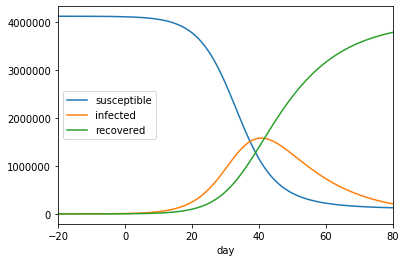

In [136]:
raw_df.set_index('day').plot()

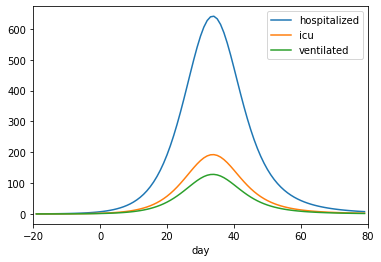

In [137]:
admits_df.set_index('day').plot()

In [138]:
actual_hsp = [np.nan,
1,
1,
1,
1,
1,
2,
2,
2,
2,
4,
4,
7,
6,
8,
13,
13,
15,]

In [139]:
actual_hsp_array = np.array(actual_hsp + [np.nan for i in range(census_df.shape[0] - len(actual_hsp))]) 
census_df['actual_hospitalized'] = actual_hsp_array

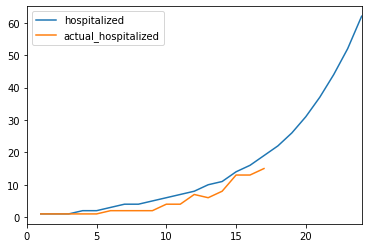

In [140]:
census_df[['hospitalized', 'actual_hospitalized']].head(25).plot()

In [73]:
census_df.set_index('day').head(30)

,hospitalized,icu,ventilated,actual_hospitalized
day,,,,
-17,NaN,NaN,NaN,NaN
-16,1.0,1.0,1.0,1.0
-15,1.0,1.0,1.0,1.0
-14,1.0,1.0,1.0,1.0
-13,2.0,1.0,1.0,1.0
-12,2.0,1.0,1.0,1.0
-11,3.0,1.0,1.0,2.0
-10,3.0,1.0,1.0,2.0
-9,4.0,2.0,1.0,2.0
